# Table of Contents
* [1. load](#1.-load)
* [2. simple words](#2.-simple-words)
* [3. filtering sample](#3.-filtering-sample)
* [4. tag sentences](#4.-tag-sentences)
* [5. parse npc extraction](#5.-parse-npc-extraction)
* [6. clean and spellcheck](#6.-clean-and-spellcheck)
	* [6.1 grammar experiment](#6.1-grammar-experiment)
* [7. MS coco captions](#7.-MS-coco-captions)
* [8. german experiments](#8.-german-experiments)


In [10]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

from copy import deepcopy
import pickle
import os
import json
from tqdm import tqdm
from tqdm import tqdm_notebook

from IPython.display import Image
import PIL.Image as pil
import random
import cv2
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light solarized
#%base16_mplrc dark solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)

import nltk
import spacy
import string
from nltk.draw.tree import TreeView
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import wordpunct_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import EnglishStemmer
from nltk.parse.stanford import StanfordParser
from nltk.tree import ParentedTree
from nltk.parse.corenlp import CoreNLPServer
from nltk.parse.corenlp import CoreNLPParser
from nltk.corpus import stopwords

from word_mod import zipf_frequency
import language_check
from fuzzywuzzy import fuzz

from anigen_tools.parsing import parse_description
from anigen_tools.parsing import sanitize_text
from anigen_tools.parsing import sentence_splitter

In [11]:
punct_set = set(string.punctuation)
punct_set.remove('.')
cached_sw = stopwords.words("english") + list(string.punctuation)

nlp = spacy.load('en')

core_nlp_base = '/Users/schwenk/wrk/animation_gan/phrase_cues/deps/stanford_core_nlp/stanford-corenlp-full-2017-06-09/'
core_parser = CoreNLPParser(url='http://localhost:9000')    

# 1. load

In [782]:
icon_list = os.listdir('/Users/schwenk/wrk/pictionary/vision-pictionary/iconary_webgame/public/images/')
icon_list = [i[:-4] for i in icon_list]

In [94]:
out_data_dir = '/Users/schwenk/wrk/pictionary/phrase_gen/sandbox-anikem/out/'

In [95]:
verb_df = pd.read_csv(out_data_dir + 'verbs.txt', header=None, names=['verb'])
situations_df = pd.read_csv(out_data_dir + 'full_situations.txt', header=None, names=['situation'])

situations_df['len'] = situations_df['situation'].apply(lambda x: len(x.split()))
verb_df['len'] = verb_df['verb'].apply(lambda x: len(x))

In [96]:
situations_df.head(1)

,situation,len
0,the person loads a cartridge holder,6


In [105]:
def least_common_word(sent):
    wlfs = [zipf_frequency(w, 'en') for w in sent.split()]
    lowest_freq = min(wlfs)
    return lowest_freq > 4

In [107]:
common_verbs = verb_df[verb_df['verb'].apply(lambda x: least_common_word(x))]

In [108]:
common_verbs.shape

(111, 2)

In [109]:
common_verbs

,verb,len
5,applying,8
11,asking,6
14,attacking,9
26,blocking,8
36,breaking,8
42,building,8
44,burning,7
49,buying,6
50,calling,7
55,carrying,8


In [88]:
# _ = situations_df['len'].hist(bins=12)

In [8]:
# verb_df.sort_values('len')

In [10]:
# ing_verbs = verb_df[verb_df['verb'].str.contains('ing')]

not abstract, easy

# 2. simple words

In [12]:
word_data_dir = '/Users/schwenk/wrk/pictionary/BasicEnglishTranslator/data/'

In [89]:
with open('./data/basic_words.csv') as f:
    read_article = f.read()

In [92]:
with open(word_data_dir + 'basic_english.pickle', 'rb') as f:
    all_words = pickle.load(f) 

In [15]:
simple_words = pd.read_csv(word_data_dir + 'basic_english_words.csv')

In [94]:
simple_words.head(1)

,WORD
0,a


# 3. filtering sample

In [690]:
gram_checker = language_check.LanguageTool('en-US')
gram_checker.disabled = set(['UPPERCASE_SENTENCE_START'])
# gram_checker.disable_spellchecking()

def grammar_check_phrases(dataset):
    corrected = {}
    passed = []
    for sentence in dataset:
        corrections = gram_checker.check(sentence)
        if corrections:
            corrected[sentence] = corrections
        else:
            passed.append(sentence)
    return corrected, passed

In [174]:
description_corpus = ' '.join(situations_df['situation'])

tokenized_corpus = word_tokenize(description_corpus)

normalized_tokens = []
for toke in tokenized_corpus:
    clean_toke = toke.strip().lower()
    if clean_toke not in cached_sw and clean_toke:
        normalized_tokens.append(clean_toke)

In [23]:
word_counts = Counter(normalized_tokens)
most_common = word_counts.most_common(200)

In [24]:
filtered_words = [w for w, count in word_counts.items() if count == 1]

In [95]:
sentences = list(set(situations_df['situation'].tolist()))

In [97]:
test_sent = sentences[1]

In [33]:
# sent_gram_errors, passed_sents = grammar_check_phrases(tqdm(sentences))

In [165]:
len(passed_sents) / len(sentences)

0.9645086556406461

In [164]:
len(passed_sents)

59950

# 4. tag sentences

In [644]:
def get_pos_tags(sentence):
    constituent_parse  = [list(i)[0] for i in core_parser.raw_parse_sents([sentence])][0]
    pos_tags = constituent_parse.pos()
    return pos_tags

def filter_pos_tags(tagged_sent):
    include_as_article = []
    for word, tag in tagged_sent:
        if tag == 'DT':
            include_as_article.append('True')
        else:
            include_as_article.append('False')
    return include_as_article

def least_common_word(sent, freq_thresh=4.7):
    wlfs = [zipf_frequency(w, 'en') for w in sent.split()]
    lowest_freq = min(wlfs)
    return lowest_freq > freq_thresh

def form_strings(tagged_sentence):
    words = [w[0] for w in tagged_sentence]
    include_word = filter_pos_tags(tagged_sentence)
    return f"{' '.join(words)} # {' '.join(include_word)}"

def form_strings_w_pos(tagged_sentence):
    words = [w[0] for w in tagged_sentence]
    include_word = [w[1] for w in tagged_sentence]
    return f"{' '.join(words)} # {' '.join(include_word)}"

In [187]:
with open('./data/unique_parsed_sents.pkl', 'rb') as f:
    unique_parsed_sents = pickle.load(f)

In [216]:
simple_sentences = [sent for sent in unique_parsed_sents if least_common_word(sent, 3.7)]

In [217]:
import matplotlib

In [253]:
colors = list(matplotlib.colors.cnames.keys())

In [417]:
word_blacklist = set(['uses', 'using', 'people', 'helped', 'measures', 'records', 'data', 'works', 'teach', 'body', 'with', 'training', 'waste', 'plastic', 'gravity', 'commission', 'space'] + colors)

In [424]:
blacklist_removed = [s for s in simple_sentences if not set([w.lower() for w in s.split()]).intersection(word_blacklist)]

In [425]:
random.choice(blacklist_removed)

'a young buck fries a meat'

In [426]:
len(blacklist_removed)

14050

In [223]:
len(blacklist_removed)

14487

In [171]:
random.choice(simple_sentences)

'a man works on a construction'

In [173]:
def filter_on_freq(sent, higher_freq, lower_freq):
    wlfs = [zipf_frequency(w, 'en') for w in sent.split()]
    lowest_freq = min(wlfs)
    return higher_freq > lowest_freq > lower_freq

In [183]:
freq_filt_words = [t for t in normalized_tokens if filter_on_freq(t, 4.7, 3)]

In [46]:
# with open('unique_parsed_sents.pkl', 'wb') as f:
#     pickle.dump(unique_parsed_sents, f)

In [47]:
some_sents = unique_parsed_sents[3]

In [428]:
chosen_sample = blacklist_removed
tagged_sentences = [get_pos_tags(s) for s in chosen_sample]

In [430]:
vocab_complete = list(set(normalized_tokens))
vocab = list(set([w[0].lower() for s in tagged_sentences for w in s if w[1] in ['NN', 'NNS', 'NNP', 'NNPS']]))

In [431]:
voc_ser = pd.Series(vocab)

voc_ser.to_csv('cleaned_sentences_nouns_harder.txt', index=False, header=None)

In [432]:
voc_ser.shape

(1663,)

In [435]:
build_output = pd.Series([form_strings(s) for s in tagged_sentences])
build_output.to_csv('cleaned_sentences_harder_pos_tags.txt', index=False, header=None)

In [ ]:
# def custom_filter_sentences(sentences):
#     required = ['a ', 'the ']
#     filtered = []
#     for sent in sentences:

# 5. parse npc extraction

In [24]:
s1 = constituent_parse[1]
TreeView(s1)._cframe.print_to_file('s2.ps')

In [2231]:
grammar = r"""
  NP: {<DT|PP\$>?<JJ>*<NN>}   # chunk determiner/possessive, adjectives and noun
  {<NNP>+}                # chunk sequences of proper nouns
  {<NN>+}                 # chunk consecutive nouns
  """




cp = nltk.RegexpParser(grammar)
parsed_sent = cp.parse(sent_parses[0])
for npstr in extract_np(parsed_sent):
    print (npstr)

The red-haired businessman
accountant
the phone
his office


In [100]:
def extract_np(psent):
    for subtree in psent.subtrees():
        if subtree.label() == 'NP':
            subprod = subtree.productions()[0].unicode_repr()
            if 'NN' in subprod or 'NNP' in subprod:
                yield ' '.join(word for word in subtree.leaves())


def compute_token_spans(const_parse_sent, txt):
    tokens = const_parse_sent.leaves()
    offset = 0
    for token in tokens:
        offset = txt.find(token, offset)
        yield token, offset, offset+len(token)
        offset += len(token)

        
def assign_word_spans(noun_phrases_w_spans, doc, token_spans):
    chunk_spans = []
    for np in noun_phrases_w_spans:
        char_span = [(m.start(), m.end()) for m in re.finditer(np, doc)][0]
        start, end = char_span
        start_w, end_w = None, None
        for w_idx, token_span in enumerate(token_spans):
            token, ts, te = token_span
            if ts == start:
                start_w = w_idx
            if te == end:
                end_w = w_idx + 1
        if type(start_w) == int and type(end_w) == int:
            chunk_spans.append([start_w, end_w])
        else:
            print('failed')
    return chunk_spans


def np_chunker(doc, parsed_sents):
    noun_phrases = [list(extract_np(sent)) for sent in parsed_sents]
#     noun_phrase_spans = [list(extract_np_spans(doc, sent)) for sent in noun_phrases]
    token_spans = [list(compute_token_spans(sent, doc)) for sent in parsed_sents]
    noun_phrase_spans = [assign_word_spans(noun_phrases[n], doc, token_spans[n]) for n in range(len(parsed_sents))]
    return {'chunks': noun_phrase_spans, 'named_chunks': noun_phrases}

# 6. clean and spellcheck

In [689]:
import enchant

# import difflib
# import diff_match_patch

# dmp = diff_match_patch.diff_match_patch()

edict = enchant.Dict("en_US")
anglo_edict = enchant.Dict("en_UK")
cached_sw = stopwords.words("english") + list(string.punctuation)

main_characters = {
}

other_chars_names = []

other_words = []

words_to_remove = []

_ = [edict.remove_from_session(word) for word in words_to_remove]
_ = [[edict.add(char_word.lower()) for char_word in char.split()] for char in list(main_characters) + other_chars_names + other_words]

_ = [anglo_edict.remove_from_session(word) for word in words_to_remove]

manual_corrections = {
                     }

def check_mispelled(word):
    return word and word.isalpha() and not (edict.check(word))

def check_word_rules(word):
    split_len = 2 < min([len(w) for w in word.split()])
    not_proper = word[0].islower()
    return not_proper and split_len

def correct_spelling_error(misspelled_word):
    if misspelled_word in manual_corrections:
        return manual_corrections[misspelled_word]
    suggested_spellings = edict.suggest(misspelled_word)
    match_ratios = [fuzz.token_sort_ratio(misspelled_word, word) for word in suggested_spellings]
    words_sorted_by_ratio = sorted(zip(suggested_spellings, match_ratios), key=lambda x: x[1], reverse=True)
    words_sorted_by_ratio = [wordscore for wordscore in words_sorted_by_ratio if check_word_rules(wordscore[0])]
    check_compounds = [word[0] for word in words_sorted_by_ratio if word[0].replace(' ', '') == misspelled_word]
    if check_compounds:
        return check_compounds[0]
    if words_sorted_by_ratio[0][1] > 80:
        return words_sorted_by_ratio[0][0]

    for word, score in words_sorted_by_ratio:
        if score >= 75 and word[0] == misspelled_word[0]:
            return word
        elif score >= 75:                    
            return word
    return None

def apply_spelling_fix(orig_text):
    orig_text_tokens = wordpunct_tokenize(orig_text)
    processed_tokens = []
    for token in orig_text_tokens:
        norm_token = token.lower()
        if len(norm_token) < 4:
            processed_tokens.append(token)
            continue
        if check_mispelled(norm_token):
            suggested_replacements = edict.suggest(token)
            replacement_text = correct_spelling_error(norm_token, suggested_replacements)
            if replacement_text:
                if norm_token[0].isupper():
                    replacement_text = upper(replacement_text[0]) + replaced_text[1:]
                processed_tokens.append(replacement_text)
            else:
                processed_tokens.append(token)
        else:
            processed_tokens.append(token)
    return ' '.join(processed_tokens)

def diff_corrected_text(orig_text, corrected_text):
    diff = dmp.diff_main(orig_text, corrected_text)
    return HTML(dmp.diff_prettyHtml(diff))

def specify_lesson_q_path(lesson):
    pass

def apply_spelling_and_grammar_to_ds(ck12_ds):
    return

def spellcheck_entry(entry_words):
    misspellings = [check_mispelled(word) for word in entry_words]
    if sum(misspellings):
        for idx, is_mispelled in enumerate(misspellings):
            if is_mispelled:
                suggested_replacement = correct_spelling_error(entry_words[idx])
                if suggested_replacement:
#                     words_changed.append([char_name_words[idx], suggested_replacement])
                    entry_words[idx] = suggested_replacement
        return entry_words
    else:
        return None

def spellcheck_video(video):
    corrected_words = []
    for entity in video._data['characters'] + video._data['objects']:
        if 'entityLabel' not in entity.data().keys():
            pass
        entry_words = wordpunct_tokenize(entity.data()['entityLabel'])
#         print(entry_words)
        new_corrected_words = spellcheck_entry(entry_words)
        if new_corrected_words:
            entity._data['originalSpelling'] = entity._data['entityLabel']
            entity._data['entityLabel'] = ' '.join(new_corrected_words).replace(' , ', ', ').replace(' . ', '.')
            corrected_words.append(new_corrected_words)
    description_words = wordpunct_tokenize(video.description())
    new_corrected_words = spellcheck_entry(description_words)
    if new_corrected_words:
        video._data['originalDescription'] = video._data['description']
        video._data['description'] = ' '.join(new_corrected_words).replace(' , ', ', ').replace(' . ', '.')
        corrected_words.append(new_corrected_words)
    return corrected_words

def spellcheck_dataset(dataset):
    corrected = {}
    for vid in dataset:
        try:
            corrections = spellcheck_video(vid)
            if corrections:
                corrected[vid.gid()] = corrections
        except:
            pass
#             print(vid.gid())
    return corrected

def grammar_check_video(video):
    all_errors = []
    for entity in video._data['characters']:
        errors = gram_checker.check(entity.data()['entityLabel'])
        if errors:
            all_errors.append(errors)
    return all_errors

def grammar_check_dataset(dataset):
    corrected = {}
    for vid in dataset:
        corrections = grammar_check_video(vid)
        if corrections:
            corrected[vid.gid()] = corrections
    return corrected

## 6.1 grammar experiment

In [12]:
import language_check

gram_checker = language_check.LanguageTool('en-US')
gram_checker.disabled = set(['UPPERCASE_SENTENCE_START'])
gram_checker.disable_spellchecking()

In [16]:
desc_with_errors = {}
corrected_desc = {}
for diag, desc_text in diagram_desc_dict.items():
    errors = gram_checker.check(desc_text)
    if errors:
        desc_with_errors[diag] = errors
        corrected_desc[diag] = gram_checker.correct(desc_text)

In [58]:
import viterbi_tagger, perceptron_tagger, cfg

# test values for developers
test_sentence = ["I", "saw", "the", "duck"]
cfg_test = ["NNP","VBD","NNP"]
from nltk.corpus import conll2000, brown

In [ ]:
# Build HMM
print("Generating Hidden Markov Model...")
viterbi_tagger = viterbi_tagger.PartOfSpeechTagger()
# Build probability distributions for each of the corpora we want to use
print("Building POS tag probability distributions based on...")
print("Corpora 1: Conll2000,")
viterbi_tagger.buildProbDist(conll2000)
print("Corpora 2: Brown.")
viterbi_tagger.buildProbDist(brown)

In [ ]:
#Train the AP Tagger weights
print("Prepare Averaged Perceptron tagger based on tagged corpora")
# taggerAP = perceptron_tagger.AP_Tagger(False)
#
# Build CFG rule set based on treebank
print("Generating Context Free Grammar based on Treebank...")
cfg_checker = cfg.Grammar()
tbank_grammar = cfg_checker.buildFromTreebank()
#
# Loop input to get and check sentences
print("If an input word is not in the corpora, the averaged perceptron \
tagger will be used instead of the Viterbi tagger.\n")

In [ ]:
# while True:
#     tag_sequence = viterbi_tagger.inputToPOS()
#     print("TAG SEQUENCE:", tag_sequence)
#     cfg_checker.verify(tbank_grammar, tag_sequence)

# 7. MS coco captions

In [12]:
with open('/Users/schwenk/wrk/pictionary/coco/annotations/captions_train2014.json') as f:
    coco_captions = json.load(f)

In [641]:
caption_sentences = [c['caption'] for c in coco_captions['annotations']]

In [642]:
len(caption_sentences)

414113

In [25]:
caption_corpus = [w for s in tqdm(caption_sentences) for w in word_tokenize(s)]

# tokenized_corpus = word_tokenize(caption_corpus)

100%|██████████| 414113/414113 [00:45<00:00, 9010.75it/s]


In [26]:
caption_token_set = list(set(caption_corpus))

In [50]:
normalized_tokens = []
for toke in tqdm(caption_corpus):
    clean_toke = toke.strip().lower()
    if clean_toke not in cached_sw and clean_toke:
        normalized_tokens.append(clean_toke)

100%|██████████| 4680702/4680702 [00:14<00:00, 322245.31it/s]


In [51]:
token_counts = Counter(normalized_tokens)

In [643]:
token_counts.most_common(100)

[('man', 51530),
 ('sitting', 36823),
 ('two', 34093),
 ('standing', 30060),
 ('people', 29662),
 ('next', 25916),
 ('white', 25383),
 ('woman', 24220),
 ('table', 21318),
 ('street', 21190),
 ('holding', 19435),
 ('person', 17428),
 ('large', 17179),
 ('top', 15478),
 ('group', 15245),
 ('field', 14655),
 ('small', 14126),
 ('near', 13714),
 ('tennis', 13652),
 ('front', 13527),
 ('black', 13395),
 ('plate', 12997),
 ('room', 12939),
 ('train', 12758),
 ('riding', 12672),
 ('dog', 12669),
 ('red', 12080),
 ('young', 11952),
 ('cat', 11731),
 ('water', 11534),
 ('baseball', 11398),
 ('walking', 10327),
 ('playing', 10257),
 ('bathroom', 10111),
 ('sign', 9714),
 ('blue', 9573),
 ('food', 9394),
 ('kitchen', 9366),
 ('grass', 9215),
 ('bus', 8990),
 ('pizza', 8791),
 ('parked', 8775),
 ('green', 8736),
 ('side', 8571),
 ('building', 8376),
 ('looking', 8348),
 ('snow', 8317),
 ('bed', 8288),
 ('ball', 7989),
 ('beach', 7953),
 ('couple', 7851),
 ('three', 7774),
 ('boy', 7768),
 ('men',

In [49]:
len(normalized_tokens)

31498

In [48]:
random.choice(caption_sentences)

'A group of teddy bears are in a basket.'

In [650]:
cap_df = pd.DataFrame(caption_sentences)
cap_df.columns = ['cap']

In [652]:
cap_df['len'] = cap_df['cap'].str.len()

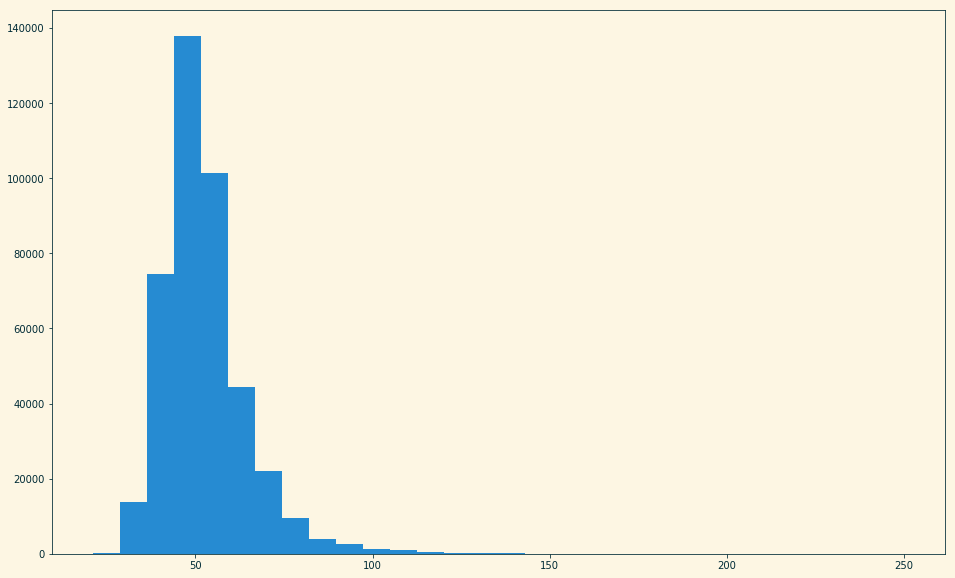

In [654]:
cap_df['len'].hist(bins=30)

In [671]:
cap_len_thresh = 30
short_caps = cap_df[cap_df['len'] < 35]

In [672]:
short_cap_l = short_caps['cap'].tolist()

In [673]:
len(short_cap_l)

6051

In [674]:
blacklist_removed = [s for s in simple_sentences if not set([w.lower() for w in s.split()]).intersection(word_blacklist)]

In [675]:
common_short = [c for c in tqdm(short_cap_l) if least_common_word(c, 4)]

100%|██████████| 6051/6051 [00:00<00:00, 58634.96it/s]


In [676]:
len(common_short)

3446

In [677]:
common_short[:10]

['six people on a bus at night time',
 'A woman in green is riding a bike.',
 'This is a bathroom sink in a hotel',
 'A view of a mirror in a bathroom.',
 'Guy reading with a dog on his lap.',
 'A car is shown next to other cars.',
 'A man with his through a fake tv.',
 'This is a toilet with a black top\n',
 'A cat is sitting next to a car.',
 'A man holding a baby in a kitchen.']

In [680]:
color_set = set(colors)

In [683]:
blacklist_removed = [s for s in common_short if not set([w.lower() for w in s.split()]).intersection(color_set)]

In [684]:
len(blacklist_removed)

3013

In [685]:
blacklist_removed

['six people on a bus at night time',
 'This is a bathroom sink in a hotel',
 'A view of a mirror in a bathroom.',
 'Guy reading with a dog on his lap.',
 'A car is shown next to other cars.',
 'A man with his through a fake tv.',
 'A cat is sitting next to a car.',
 'A man holding a baby in a kitchen.',
 'a public transit bus at a bus stop',
 'Two men sit laughing on a bench. ',
 'a counter top with a plate of food',
 'a toy ,with a dog riding a bike ',
 'A cat is lying awake on a car hood',
 'A bunch of food on a counter top.',
 'A dog and a man play in the snow.',
 'A man on his laptop in the kitchen',
 'A picture of a sink in a bathroom.',
 'A bird sits on top of a car',
 'A picture of a bike by a building.',
 'A picture of a bike on the road.',
 'New bike is taken out of its box.',
 'A little girl plays with a toy gun',
 'A woman mixing some food in a pot.',
 'a young woman uses her cell phone ',
 'A woman who has a cat on her back.',
 'A bathroom door with a sink by it.',
 'A sid

In [686]:
voc_ser = pd.Series(blacklist_removed)
voc_ser.to_csv('simple_coco_captions.txt', index=False, header=None)

In [687]:
len(blacklist_removed)

3013

In [691]:
sent_gram_errors, passed_sents = grammar_check_phrases(tqdm(blacklist_removed))

100%|██████████| 3013/3013 [00:24<00:00, 120.67it/s]


In [692]:
len(passed_sents)

2885

In [763]:
nuisance_phrases = ['a picture of ', 'this is ', 'there is ', ' shown ', 'an image of ', 'view of a ', 'close up of ']

def normalize_sent(sent):
    nsent = sent.lower()
    for np in nuisance_phrases:
        nsent = nsent.replace(np, '')
    nsent = nsent[0].upper() + nsent[1:]
    if nsent[-1] not in ['.', '!']:
        nsent += '.'
    
    return nsent

In [764]:
normed_sents = list(set([normalize_sent(s) for s in passed_sents if 'image' not in s]))

In [765]:
len(normed_sents)

2497

In [766]:
normed_sents

['A bucket is next to the toilet. \n.',
 'A cat sitting on top of a man lap.',
 'A boat is in the middle of a lake.',
 'A man enjoying a ride on a bike.',
 'A pot is full of some food cooking.',
 'A a horse in a field.',
 'A jet inside of a museum show room.',
 'A bench at a park near the grass. .',
 'A man playing a piano in a room.',
 'New bike is taken out of its box.',
 'A small clock is next to a shelf.',
 'Some type of sand which on a plate.',
 'A man is holding up a toy guitar.',
 'A dog is in a boat on the lake.',
 'A cat sitting on a bag and a map.',
 'A man playing a pro sport.',
 'A large bus and truck on a street.',
 'A cat stands on top of a horse .',
 'A table that has a computer on it.',
 'A sign on a wall on a street.',
 'A young boy is sitting at a table.',
 'A guy with a hot dog at a fair.',
 'A laptop turned on laying on a bed.',
 'A big animal inside of a big cage.',
 'A man in a suit holding a glass.',
 'A clock on a shelf with some books.',
 'A cat is looking out 

In [767]:
tagged_sentences = [get_pos_tags(s) for s in tqdm(normed_sents)]

100%|██████████| 2497/2497 [00:39<00:00, 62.81it/s]


In [768]:
verb_tags = set(['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'])

In [769]:
sents_w_verbs = [ts[:-1] for ts in tagged_sentences if set([t[1] for t in ts]).intersection(verb_tags)]

In [770]:
len(sents_w_verbs)

1409

In [771]:
build_output = pd.Series([form_strings(s) for s in sents_w_verbs])
build_output.to_csv('simple_coco.txt', index=False, header=None)

build_output = pd.Series([form_strings_w_pos(s) for s in sents_w_verbs])
build_output.to_csv('simple_coco_tagged.txt', index=False, header=None)

# 8. german experiments

In [468]:
german_words = pd.read_csv('./german_10k.txt', sep=' ', header=None).T
german_words.columns = ['raw_word']

german_words = german_words[german_words['raw_word'].str.isalpha().fillna(False)]

In [472]:
german_words['len'] = german_words.raw_word.str.len()

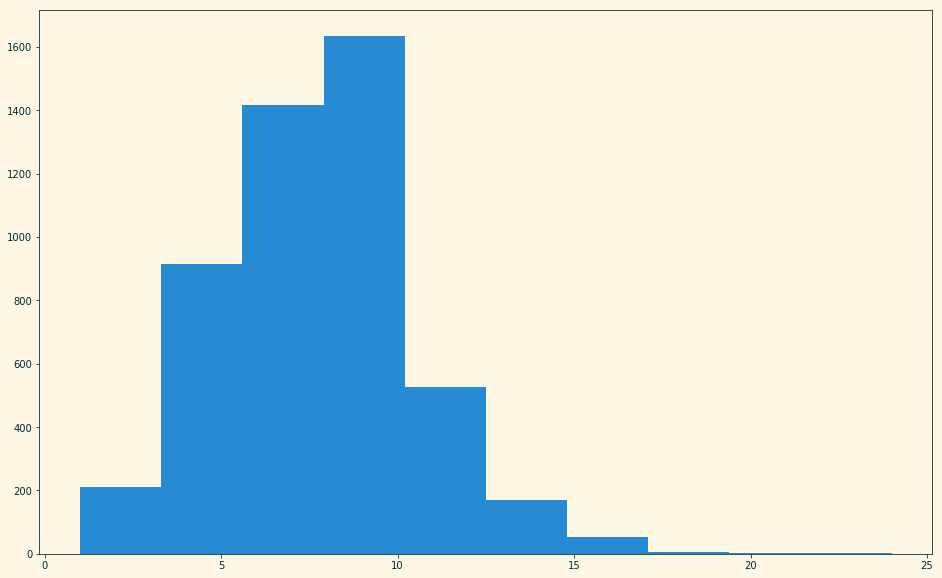

In [475]:
german_words.len.hist()

In [478]:
long_words = german_words[german_words['len'] > 15]

In [485]:
from googletrans import Translator
translator = Translator(service_urls=[
      'translate.google.com',
    ])

In [481]:
long_words

,raw_word,len
91,zusammengearbeitet,18
323,wwwentouragetvde,16
755,Leichenschauhaus,16
899,Gesichtsausdruck,16
1353,Waffenstillstand,16
1659,Verteidigungsministerium,24
1935,außergewöhnliche,16
2661,Entschuldigungen,16
2897,Sicherheitssystem,17
2979,Gehirnerschütterung,19


In [489]:
to_trans = long_words['raw_word'].tolist()

In [492]:
translations = translator.translate(to_trans, dest='en')

In [498]:
translator.translate('forest fire', dest='de').text

'Waldbrand'

In [506]:
from wiktionaryparser import WiktionaryParser

In [510]:
parser = WiktionaryParser()
word = parser.fetch('test')
another_word = parser.fetch('Aasfresser', 'german')
parser.set_default_language('french')

In [511]:
another_word

[{'definitions': [{'examples': [],
    'partOfSpeech': 'noun',
    'relatedWords': [{'relationshipType': 'synonyms',
      'words': ['Nekrophage']}],
    'text': 'Aasfresser\xa0m (genitive Aasfressers, plural Aasfresser)\nscavenger (an animal that feeds on carrion)\n'}],
  'etymology': 'Aas +\u200e Fresser (from fressen + -er "-er")',
  'pronunciations': {'audio': ['//upload.wikimedia.org/wikipedia/commons/5/52/De-Aasfresser.ogg'],
   'text': ['IPA: /ˈaːsˌfʀɛsɐ/']}}]

# wordnet 

In [540]:
from nltk.corpus import wordnet

In [630]:
def get_word_sisters(word):
    sister_words_syn = []
    sister_words = []
    for syn in wordnet.synsets(word):
        print(syn)
        if syn.pos() != 'n':
            continue
        for hyper in syn.hypernyms():
            for hypo in hyper.hyponyms():
                sister_words_syn.append(hypo)
                sister_words.extend(hypo.lemma_names())
        break
    return sister_words, sister_words_syn

In [637]:
test_word = 'toast'
sis_words, ssyns = get_word_sisters(test_word)

Synset('toast.n.01')


In [638]:
sis_words

['anadama_bread',
 'bap',
 'barmbrack',
 'breadstick',
 'bread-stick',
 'brown_bread',
 'Boston_brown_bread',
 'bun',
 'roll',
 'caraway_seed_bread',
 'challah',
 'hallah',
 'cinnamon_bread',
 'cracked-wheat_bread',
 'cracker',
 'crouton',
 'dark_bread',
 'whole_wheat_bread',
 'whole_meal_bread',
 'brown_bread',
 'English_muffin',
 'flatbread',
 'garlic_bread',
 'gluten_bread',
 'Host',
 'loaf_of_bread',
 'loaf',
 'matzo',
 'matzoh',
 'matzah',
 'unleavened_bread',
 'nan',
 'naan',
 'onion_bread',
 'quick_bread',
 'raisin_bread',
 'rye_bread',
 'salt-rising_bread',
 'simnel',
 'sour_bread',
 'sourdough_bread',
 'toast',
 'wafer',
 'white_bread',
 'light_bread']

In [565]:
tsns = ssyns[0]

In [640]:
# for syn in wordnet.synsets(test_word):
#     print(syn.definition())